# Homework 4: Functions and Histograms

Please complete this notebook by filling in the cells provided. When you’re done:

1. Select `Run All` from the `Cell` menu to ensure that you have executed all cells.
2. Rename your file to `LastnameFirstname_hw04` using the `File>Rename` from the `File` menu

This assignment is due Thursday, February 21 at 11:59PM.  Directly sharing answers is not okay, but discussing problems with course staff or with other students is encouraged.

Reading:
- Textbook chapters [7](https://www.inferentialthinking.com/chapters/07/Visualization.html) and [8](https://www.inferentialthinking.com/chapters/08/Functions_and_Tables)

Run the cell below to prepare the notebook and the tests. **Passing the automatic tests does not guarantee full credit on any question.** The tests are provided to help catch some common errors, but it is *your* responsibility to answer the questions correctly.

In [18]:
# Run this cell to set up the notebook, but please don't change it.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

from client.api.assignment import load_assignment
tests = load_assignment('hw04.ok')

WARNING  | guidance.py:102 | Failed to read .ok_guidance file. It may not exist


Assignment: Homework 4: Functions and Histograms
OK, version v1.13.11



## 1. Predicting Temperatures


In this exercise, we will try to predict the weather in California using the prediction method  discussed in [section 8.1 of the textbook](https://www.inferentialthinking.com/chapters/08/1/Applying_a_Function_to_a_Column).  Much of the code is provided for you; you will be asked to understand and run the code and interpret the results.

The US National Oceanic and Atmospheric Administration (NOAA) operates thousands of climate observation stations (mostly in the US) that collect information about local climate.  Among other things, each station records the highest and lowest observed temperature each day.  These data, called "Quality Controlled Local Climatological Data," are publicly available [here](http://www.ncdc.noaa.gov/orders/qclcd/) and described [here](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/quality-controlled-local-climatological-data-qclcd).

`temperatures.csv` contains an excerpt of that dataset.  Each row represents a temperature reading in Fahrenheit from one station on one day.  (The temperature is actually the highest temperature observed at that station on that day.)  All the readings are from 2015 and from California stations.

In [19]:
temperatures = Table.read_table("temperatures.csv")
temperatures

Temperature,Date,Latitude,Longitude,Station name
67,1013,40.9781,-124.109,Arcata/Eureka
63,811,38.3208,-123.075,Bodega
94,706,39.1019,-121.568,Marysville
59,1211,36.9358,-121.789,Watsonville
111,620,32.8342,-115.579,Imperial
88,821,33.9,-117.25,Riverside
68,606,33.938,-118.389,Los Angeles
66,205,37.2847,-120.513,Merced
89,902,39.49,-121.618,Oroville
105,728,34.8536,-116.786,Daggett


Here is a scatter plot:

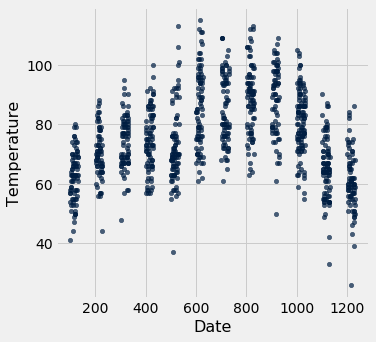

In [20]:
temperatures.scatter("Date", "Temperature")

Each entry in the column "Date" is a number in MMDD format, meaning that the last two digits denote the day of the month, and the first 1 or 2 digits denote the month.

**Question 1.** Why do the data form vertical bands with gaps?

The x axis is kind of set up to accomodate continuous values but the data jumps by month (1XX to 2XX) without any days past 31, so there will be gaps.

Let us solve that problem.  We will convert each date to the number of days since the start of the year.

In [21]:
def get_month(date):
    """The month in the year for a given date.
    
    >>> get_month(315)
    3
    """
    return int(date / 100)

def get_day_in_month(date):
    """The day in the month for a given date.
    
    >>> get_day_in_month(315)
    15
    """
    return date % 100

DAYS_IN_MONTHS = Table().with_columns(
    "Month", np.arange(1, 12+1),
    "Days in Month", make_array(31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31))

# A table with one row for each month.  For each month, we have
# the number of the month (e.g. 3 for March), the number of
# days in that month in 2015 (e.g. 31 for March), and the
# number of days in the year before the first day of that month
# (e.g. 0 for January or 59 for March).
DAYS_SINCE_YEAR_START = DAYS_IN_MONTHS.with_column(
    "Days since start of year", np.cumsum(DAYS_IN_MONTHS.column("Days in Month")) - DAYS_IN_MONTHS.column("Days in Month"))

def days_since_year_start(month):
    """The number of days in the year before this month starts.
    
    month should be the number of a month, like 3 for March.
    
    >>> days_since_year_start(3)
    59
    """
    return DAYS_SINCE_YEAR_START.where("Month", are.equal_to(month))\
                                .column("Days since start of year")\
                                .item(0)

# First, extract the month and day for each reading.
with_month_and_day = temperatures.with_columns(
    "Month", temperatures.apply(get_month, "Date"),
    "Day in month", temperatures.apply(get_day_in_month, "Date"))
# Compute the days-since-year-start for each month and day.
fixed_dates = with_month_and_day.apply(days_since_year_start, "Month") + with_month_and_day.column("Day in month")
# Add those to the table.
with_dates_fixed = with_month_and_day.with_column("Days since start of year", fixed_dates).drop("Month", "Day in month")
with_dates_fixed

Temperature,Date,Latitude,Longitude,Station name,Days since start of year
67,1013,40.9781,-124.109,Arcata/Eureka,286
63,811,38.3208,-123.075,Bodega,223
94,706,39.1019,-121.568,Marysville,187
59,1211,36.9358,-121.789,Watsonville,345
111,620,32.8342,-115.579,Imperial,171
88,821,33.9,-117.25,Riverside,233
68,606,33.938,-118.389,Los Angeles,157
66,205,37.2847,-120.513,Merced,36
89,902,39.49,-121.618,Oroville,245
105,728,34.8536,-116.786,Daggett,209


**Question 2.** In the cell above, what is the value of this expression?

    np.cumsum(DAYS_IN_MONTHS.column("Days in Month")) - DAYS_IN_MONTHS.column("Days in Month")
    
Describe its type and what its value (or the values in it, if it's an array or table) means.

*Hint:* You can write `np.cumsum?` to get documentation for the function `cumsum`.

In [22]:
np.cumsum(DAYS_IN_MONTHS.column("Days in Month")) - DAYS_IN_MONTHS.column("Days in Month")

array([  0,  31,  59,  90, 120, 151, 181, 212, 243, 273, 304, 334])

It is an array that keeps track of how many days since "January 00" has passed. January 1 shows a value of zero because it only considers the day before the start of the month. If you add 31 to 334 (the last value of array), it equals 365 so all of the year's days are counted.

Now we can make a better scatter plot.

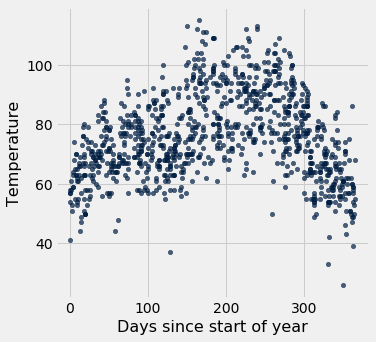

In [23]:
with_dates_fixed.scatter("Days since start of year", "Temperature")

Let's do some prediction.  For any reading on any day, we will predict its value using all the readings from the week before and after that day.  A reasonable prediction is that the reading will be the average of all those readings.  We will package our code in a function.

In [24]:
PREDICTION_RADIUS = 7

def predict_temperature(day):
    """A prediction of the temperature (in Fahrenheit) on a given day at some station.
    """
    nearby_readings = with_dates_fixed.where("Days since start of year", are.between_or_equal_to(day - PREDICTION_RADIUS, day + PREDICTION_RADIUS))
    return np.average(nearby_readings.column("Temperature"))

**Question 3.** Suppose you're planning a trip to Yosemite for Thanksgiving break this year, and you'd like to predict the temperature on November 26 (the Saturday after Thanksgiving). Use `predict_temperature` to compute a prediction for a temperature reading on that day.

*Hint:* In addition to `predict_temperature`, another function we wrote earlier will be helpful.

In [25]:
thanksgiving_prediction = predict_temperature(days_since_year_start(11)+26)
thanksgiving_prediction

64.31914893617021

In [26]:
_ = tests.grade('q1_3')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Below we have computed a predicted temperature for each reading in the table and plotted both.  (It may take a **minute or two** to run the cell.)

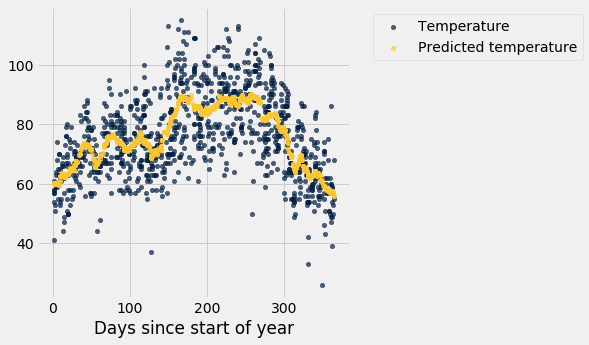

In [27]:
with_predictions = with_dates_fixed.with_column(
    "Predicted temperature",
    with_dates_fixed.apply(predict_temperature, "Days since start of year"))
with_predictions.select("Days since start of year", "Temperature", "Predicted temperature")\
                .scatter("Days since start of year")

**Question 4.** How many times was the first line of the body of the function `predict_temperature` (the one that starts with `nearby_readings = ...`) executed when you ran the cell above?

The cell above took table with_dates_fixed with 1000 rows and the function predict_temperature was applied/executed that many times.

**Question 5.** The scatter plot is called a *graph of averages*.  In the [example in the textbook](https://www.inferentialthinking.com/chapters/08/1/Applying_a_Function_to_a_Column#Example:-Prediction), the graph of averages roughly followed a straight line.  Is that true for this one?  Using your knowledge about the weather, explain why or why not.

It is not a straight line. The data starts at January when it is winter and ends in December when it is winter so it makes sense that we see a rise and fall of temperatures. If it were linear, that would mean that December would have to be hotter than August

**Question 6.** According to the [Wikipedia article](https://en.wikipedia.org/wiki/Climate_of_California) on California's climate, "[t]he climate of California varies widely, from hot desert to subarctic."  Suppose we limited our data to weather stations in a smaller area whose climate varied less from place to place (for example, the state of Vermont, or the San Francisco Bay Area).  If we made the same graph for that dataset, in what ways would you expect it to look different?

The vertical spread of our data points would be closer together. Since only a small region woud be plotted, seeing readings for 40 and 80 degrees in around the same time would be less likely.

## 2. Reading Documents


Often, we have to work with data that aren't in CSV format, but instead come in some less nice form.  In this exercise, we'll look at the text of some Reuters news reports from 1987.  Our dataset doesn't include *all* the news reports from that year, but it includes 1,000 of them.  Reuters doesn't say how the articles were selected.

We've put the text of all the articles in a file called `reuters.txt`.  The cell below loads that file into a single big string and prints a few thousand characters, which is just enough to see one full article and the start of the next.  (Don't try to print the whole thing, because it's very long.)

In [28]:
# Just run this cell to load the dataset as one big string of text.
with open('reuters.txt', 'r') as file:
    big_reuters_string = file.read()

print("{:.5000}\n[...]".format(big_reuters_string))

<reuters cgisplit="PUBLISHED-TESTSET" lewissplit="NOT-USED" newid="12603" oldid="21460" topics="YES">
<date> 2-APR-1987 11:11:23.62</date>
<topics><d>livestock</d><d>carcass</d><d>trade</d></topics>
<places><d>usa</d><d>japan</d></places>
<people><d>lyng</d></people>
<orgs></orgs>
<exchanges></exchanges>
<companies></companies>
<unknown> 
C G L
f1408reute
u f BC-/LYNG-SETS-TOUGH-U.S.   04-02 0141</unknown>
<text>
<title>LYNG SETS TOUGH U.S. STANCE WITH JAPAN ON BEEF</title>
<dateline>    WASHINGTON, April 2 - </dateline>U.S. Agriculture Secretary Richard
Lyng warned Japan that the failure to remove a longstanding 
import quota on Japanese beef might spark a protectionist
response in the United States.
    "Given the protectionist mood in the Congress and the
country, if I were a leader in Japan I would certainly be very
concerned...and the failure to remove it (the beef quota) might
be very serious," Lyng told a group of U.S cattlemen.
    Lyng said he and Trade Representative Clayton 

There's a bunch of weird text for each article.  Each article is separated from its neighbors by the string `"***ARTICLE***"`.

**Question 1.** Use the String method `split` to make an array of the text of all the articles.  That is, each entry of this array should be the text of one article.  Put that array in a new table called `reuters` as a column with the name "Raw text".

*Hint:* When you split the articles correctly, you should see that each article starts with `"<reuters..."` and ends with `"...</reuters>"`.  There should be 1,000 articles.

*Hint 2:* As an example, `"steamcleaner".split("ea")` is the same as `make_array('st', 'mcl', 'ner')`.  So you want to split the big string that contains all the data, splitting with the text `"***ARTICLE***"`.

In [29]:
reuters = Table().with_column("Raw text", big_reuters_string.split("***ARTICLE***")        
    )
reuters

Raw text
"<reuters cgisplit=""PUBLISHED-TESTSET"" lewissplit=""NOT-US ..."
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TEST"" newid ..."
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ..."
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ..."
"<reuters cgisplit=""PUBLISHED-TESTSET"" lewissplit=""NOT-US ..."
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ..."
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ..."
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ..."
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ..."
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ..."


In [30]:
_ = tests.grade('q2_1')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Each article has a line containing its title that looks something like this:

    <title>LYNG SETS TOUGH U.S. STANCE WITH JAPAN ON BEEF</title>

You could find that yourself for a few of the articles, but it would be very tedious to do it for all 1,000 articles.  So we'll write code to do it instead.

**Question 2.** Below, we've written a function called `get_text_in_markers` that will help you find the title text for an article.  Use it to write a function called `get_title`, which is also documented below.

In [33]:
# This function is provided for you to use.  Read at least
# its documentation (the stuff at the beginning in red).
# You can also type in get_text_in_markers? somewhere and
# run it to see the documentation in a slightly nicer form.
# We haven't used any tools you haven't seen yet, so it
# wouldn't hurt to read the code itself, too.
def get_text_in_markers(text, marker):
    """Finds the part of a piece of text that's between specified markers.
    
    Parameters
    ----------
    text : str
        The text in which you want to find something.
    marker : str
        The name of the marker that delimits the part of the
        text you want to grab.  In the text itself, this string
        will be surrounded by "<>" or "</>", but don't include
        those angle brackets in this argument.
    
    Returns
    -------
    str
        The parts of the text that are inside the markers.
    
    Examples
    --------
    >>> get_text_in_markers("stuff <interesting>yay exciting</interesting> more stuff", "interesting")
    'yay exciting'
    """
    start_marker = "<{}>".format(marker)
    end_marker = "</{}>".format(marker)
    split_before = np.array(text.split(start_marker))
    marker_text_and_after = split_before.item(1)
    split_on_end_marker = np.array(marker_text_and_after.split(end_marker))
    return split_on_end_marker.item(0)

# Fill in this function.
def get_title(article_text):
    """Takes the text of an article and returns its title."""
    return get_text_in_markers(article_text,'title')

# When you're done, this should produce 'LYNG SETS TOUGH U.S. STANCE WITH JAPAN ON BEEF'.
get_title(reuters.column("Raw text").item(0))

'LYNG SETS TOUGH U.S. STANCE WITH JAPAN ON BEEF'

In [34]:
_ = tests.grade('q2_2')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 3.** Now use your function to find the title of every article in `reuters`.  Create a new table called `with_titles` that's a copy of `reuters` with an extra column named "Title" that contains these titles.

*Note:* This might take a few seconds to run.

In [35]:
with_titles = reuters.with_column('Title',reuters.apply(get_title,0))
with_titles

Raw text,Title
"<reuters cgisplit=""PUBLISHED-TESTSET"" lewissplit=""NOT-US ...",LYNG SETS TOUGH U.S. STANCE WITH JAPAN ON BEEF
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TEST"" newid ...",DE LAURENTIIS COMPANIES SEE LOSS ON FILM
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",PORTUGUESE TRADE DEFICIT NARROWS IN 1986
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",BIOGEN GETS PATENT FROM EUROPEAN OFFICE
"<reuters cgisplit=""PUBLISHED-TESTSET"" lewissplit=""NOT-US ...",DEFENSE CONTRACTOR BOOSTS BIRD STAKE
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",MOODY'S MAY DOWNGRADE RESORTS INTERNATIONAL
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",RECORD N.Z. FUTURES VOLUMES TRADED IN FEBRUARY
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",SWISS SIGHT DEPOSITS RISE 743.7 MLN FRANCS
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",IRAN SAYS IT INTENDS NO THREAT TO GULF SHIPPING
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",BUSINESSLAND COMPLETES OFFERING


In [36]:
_ = tests.grade('q2_3')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Now we'll go through a similar process to get the date of each article.  In each article, the date is on its own line, separated from the rest of the article by `<date>` and `</date>` markers.  You can check one of the articles for an example.

**Question 4.** Write a function called `get_date`.  It should take as its argument the whole text of an article and return the date.  The date should be just the day of the year (so January 1 is day 1, and February 1 is day 32, since January has 31 days).  Note that all the articles are from the year 1987, so the year is irrelevant.

We've written a function called `date_string_to_day` that will help you do this.

In [37]:
# This function is provided for you to use.  Read at least
# its documentation (the stuff at the beginning in red).
def date_string_to_day(date_string):
    """Converts a string that looks like a date into the day of the year.
    
    Parameters
    ----------
    date_string : str
        Text that contains a date in any reasonable format.
        For example, "September 13, 1994" or "9/13/94" or
        "13-SEP-1994 15:02:20.00" all work.
    
    Returns
    -------
    int
        The day of the year that the date represents.
    
    Examples
    --------
    >>> date_string_to_day("January 3, 2016")
    3
    
    >>> date_string_to_day("February 4, 2000")
    35
    """
    from dateutil import parser
    import re
    # Some of the Reuters dates have extraneous text at the end.
    # This removes that text.
    date_part = re.sub(" [A-Z]*$", "", date_string)
    try:
        date = parser.parse(date_part)
    except:
        print("Failed on", date_string)
    day_in_year = date.timetuple().tm_yday
    return day_in_year

# Fill in this function.
def get_date(article_text):
    date_text = get_text_in_markers(article_text,'date')
    day_in_year = date_string_to_day(date_text)
    return day_in_year

# When you're done, this should produce 92.
get_date(reuters.column("Raw text").item(0))

92

In [38]:
_ = tests.grade('q2_4')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 5.** Use your function to find the date of every article in `with_titles`. Create a new table called `with_dates` that's a copy of `with_titles` with an extra column named "Date" that contains the dates.

In [39]:
with_dates = with_titles.with_column('Date',with_titles.apply(get_date,0))
with_dates

/home/edabdala/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname F identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/edabdala/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname RM identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/edabdala/anaconda3/lib/python3.7/site-packages/dateutil/parser/_parser.py:1204: UnknownTimezoneWarning: tzname G identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
/home/edabdala/anaconda3/lib/python3.7/site-p

Raw text,Title,Date
"<reuters cgisplit=""PUBLISHED-TESTSET"" lewissplit=""NOT-US ...",LYNG SETS TOUGH U.S. STANCE WITH JAPAN ON BEEF,92
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TEST"" newid ...",DE LAURENTIIS COMPANIES SEE LOSS ON FILM,170
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",PORTUGUESE TRADE DEFICIT NARROWS IN 1986,70
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",BIOGEN GETS PATENT FROM EUROPEAN OFFICE,85
"<reuters cgisplit=""PUBLISHED-TESTSET"" lewissplit=""NOT-US ...",DEFENSE CONTRACTOR BOOSTS BIRD STAKE,92
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",MOODY'S MAY DOWNGRADE RESORTS INTERNATIONAL,68
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",RECORD N.Z. FUTURES VOLUMES TRADED IN FEBRUARY,61
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",SWISS SIGHT DEPOSITS RISE 743.7 MLN FRANCS,82
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",IRAN SAYS IT INTENDS NO THREAT TO GULF SHIPPING,81
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",BUSINESSLAND COMPLETES OFFERING,70


In [40]:
_ = tests.grade('q2_5')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 6.** There was a series of earthquakes in Ecuador on March 6, 1987.  Most Reuters news stories about Ecuador from that period were related to the earthquake or its political and economic consequences.  Find out when Reuters reported on the earthquake by making a histogram of all the dates of the articles whose *titles* include the word `"ECUADOR"`.  Use bins of width 3.

*Hint:* The function `are.containing` creates a predicate that matches strings that contain a given string.  You can find its documentation by running `are.containing?`.

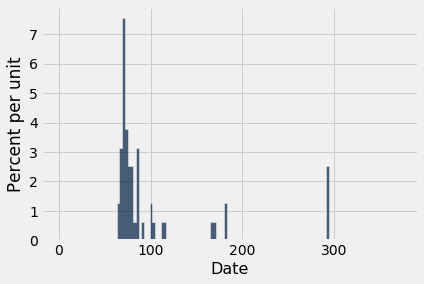

In [41]:
# Use these bins:
bins = np.arange(0, 375, 3)
with_dates.where('Title',are.containing('ECUADOR')).hist('Date',bins=bins)

**Question 7.** Make another histogram of the same data, but this time using different bins.  The first bin should start at day 0, and each bin should have a width of 10 days. Then, **using only your own inspection of the histogram (and no other Python code)**, estimate the proportion of Ecuador articles that were reported between days 50 and 100 of the year (including day 50 but not day 100). (The proportion should be out of the total number of articles whose titles include "ECUADOR".) Give that number the name `proportion_50_to_100`.

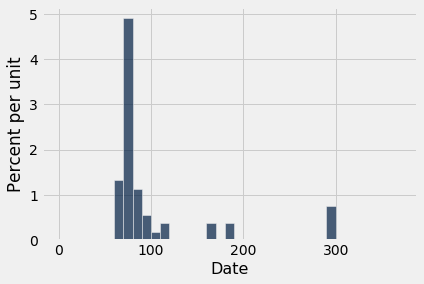

In [43]:
# Make a histogram as described above.  (Be sure to use the
# bins described in the question.)
with_dates.where('Title',are.containing('ECUADOR')).hist('Date',bins=range(0,375,10))

# By inspecting your histogram, estimate the proportion of
# Ecuador articles that were reported between days 50 and 100
# of the year.  (It's hard to get exactly the right answer
# from a histogram like this, so it's okay if your answer is
# off by a little bit.)
proportion_50_to_100 = 85

**Question 8.** Your histogram should show several long gaps in coverage about Ecuador during the year.  By exploring the dataset, try to explain this.  Use the code cell below for your explorations.

In [44]:
with_dates.where('Title',are.containing('ECUADOR')).sort('Date').show()

Raw text,Title,Date
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",ECUADOR'S CONSUMER PRICES RISE 2.5 PCT IN FEBRUARY,64
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",ECUADOR SAYS SUSPENDS OIL EXPORTS DUE EARTHQUAKE,65
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",ECUADOR ADOPTS AUSTERITY MEASURES AFTER QUAKE,66
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",ECUADOR QUAKE CAUSES 950 MLN DLRS IN LOSSES,68
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...","ECUADOR TO EXPORT NO OIL FOR FOUR MONTHS, OFFICIAL",68
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",ECUADOR QUAKE TO CUT OIL REVENUES 800 MLN DLRS,68
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...","ECUADOR TO EXPORT NO OIL FOR 4 MONTHS, OFFICIAL",68
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",ECUADOR CRUDE OIL EXPORTS STOPPED FOR FIVE MONTHS,70
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",ECUADOR MINISTER RAISES QUESTIONS ABOUT DEBT,70
"<reuters cgisplit=""TRAINING-SET"" lewissplit=""TRAIN"" newi ...",ECUADOR DEBT TO BE HONOURED AFTER QUAKE SURVIVAL,70


There is a lot of reporting of Ecuador because of an earthquake. There is a significant gap aroung days 180 and 292. Examining the headlines around this gap shows that things got better for Ecuador and when that happens, people stop caring and move on to other news.

## 3. Causes of Death in California


This exercise is designed to give you practice using the Table method `group`.

We'll be looking at a dataset from the California Department of Public Health (available [here](http://www.healthdata.gov/dataset/leading-causes-death-zip-code-1999-2013) and described [here](http://www.cdph.ca.gov/data/statistics/Pages/DeathProfilesbyZIPCode.aspx)) that records the cause of death (as recorded on a death certificate) for everyone who died in California from 1999 to 2013.  The data are in the file `causes_of_death.csv.zip`.  Each row records the number of deaths by one cause in one year in one ZIP code.

To make the file smaller, we've compressed it; run the next cell to unzip and load it.

In [45]:
from zipfile import *

ZipFile('causes_of_death.csv.zip','r').extractall()

causes = Table.read_table('causes_of_death.csv')
causes

Year,ZIP Code,Cause of Death,Count,Location
1999,90002,SUI,1,"(33.94969, -118.246213)"
1999,90005,HOM,1,"(34.058508, -118.301197)"
1999,90006,ALZ,1,"(34.049323, -118.291687)"
1999,90007,ALZ,1,"(34.029442, -118.287095)"
1999,90009,DIA,1,"(33.9452, -118.3832)"
1999,90009,LIV,1,"(33.9452, -118.3832)"
1999,90009,OTH,1,"(33.9452, -118.3832)"
1999,90010,STK,1,"(34.060633, -118.302664)"
1999,90010,CLD,1,"(34.060633, -118.302664)"
1999,90010,DIA,1,"(34.060633, -118.302664)"


The causes of death in the data are abbreviated.  If you want to know what the abbreviations mean, we've provided a table called `abbreviations.csv`.

**Question 1.** Find the top 5 causes of death in California over the entire period covered by the data.  To do that, create a table with one row for each of the top 5 causes of death, a column called "Cause of Death", and a column called "Count" that records the total number of deaths due to that cause.  Sort it in descending order by count, and call it `top_5_causes`.

In [71]:
top_5_causes = causes.select(2,3).group(0,sum).relabeled("Count sum",'Count').sort("Count",descending=True).take(range(0,5))
top_5_causes

Cause of Death,Count
HTD,957108
CAN,822906
OTH,637764
STK,231897
CLD,194961


In [72]:
_ = tests.grade('q3_1')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



**Question 2.** Create a bar chart that displays the *proportion of all deaths* by each cause.

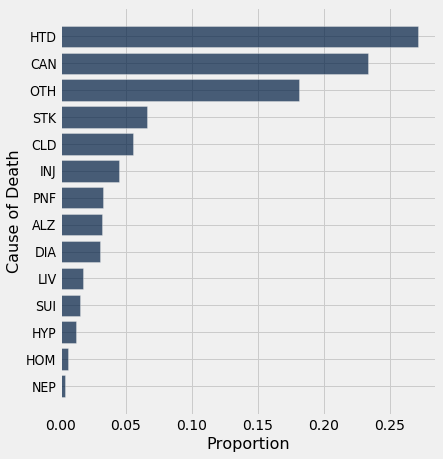

In [74]:
all_deaths = causes.column('Count').sum()
death_causes = causes.select(2,3).group(0,sum).relabeled("Count sum",'Count').sort("Count",descending=True)
proportions = death_causes.with_column("Proportion", by_causes.column('Count')/all_deaths)
with_proportions.select(0,2).barh(0)

**Question 3.** Create a plot of the total number of deaths per year in California.

*Hint:* Use the Table method `plot`.  The first argument is the name or index of the column to put on the horizontal axis.

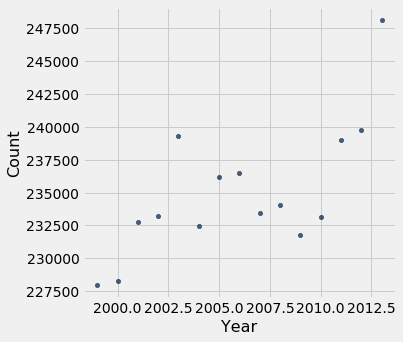

In [78]:
deaths_per_year = causes.select('Year','Count').group('Year',sum).relabeled("Count sum",'Count')
deaths_per_year.scatter('Year')

# This line will make the vertical axis start at 0.  You can remove
# it if you want to see the default plot, which is more zoomed-in.
# plt.ylim(0, 300000)

**Question 4.** You should see that deaths have increased a little over time, though not uniformly.  How would you explain that?  Describe a dataset you'd like to see to test whether your explanation is valid.

Some of the top killers in this data set are heart disease, cancer, and stroke. I dont think we have made a lot of societal progress with decreasing these numbers so they can increase over time. Would analyze news reports like we did for Equador to see if any events jump out.

In [79]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [tests.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q')]
print("Finished running all tests.")

Running all tests...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running t